# **Weather Prediction Model**

## **Import Libraries**

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Registering converters for matplotlib
pd.plotting.register_matplotlib_converters()

# Setting the style for plots to "dark"
sns.set_style("dark")

# Choosing a custom palette "rocket"
sns.set_palette("rocket")

## **Creating Dataframe**

In [27]:
df = pd.read_csv("seattle-weather.csv",index_col="date",parse_dates=True)
df_temp = df["temp_max"]

In [28]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-02,10.9,10.6,2.8,4.5,rain
2012-01-03,0.8,11.7,7.2,2.3,rain
2012-01-04,20.3,12.2,5.6,4.7,rain
2012-01-05,1.3,8.9,2.8,6.1,rain


In [29]:
df.columns

Index(['precipitation', 'temp_max', 'temp_min', 'wind', 'weather'], dtype='object')

In [30]:
# Define a mapping dictionary for weather categories to integers
weather_mapping = {'drizzle': 0, 'rain': 1, 'snow': 2, 'sunny': 3}

# Map the 'weather' column using the mapping dictionary
df['weather'] = df['weather'].map(weather_mapping)

# Print the updated DataFrame
print(df.head())

            precipitation  temp_max  temp_min  wind  weather
date                                                        
2012-01-01            0.0      12.8       5.0   4.7      0.0
2012-01-02           10.9      10.6       2.8   4.5      1.0
2012-01-03            0.8      11.7       7.2   2.3      1.0
2012-01-04           20.3      12.2       5.6   4.7      1.0
2012-01-05            1.3       8.9       2.8   6.1      1.0


In [31]:
# check if there are any null values in the dataframe
df.isnull().sum()

precipitation      0
temp_max           0
temp_min           0
wind               0
weather          741
dtype: int64

The weather column has a lot of null values. Replace the null values with the mode of the column.

In [32]:
# Calculate the mode of the 'weather' column to find out the factor that occurs most frequently
mode_weather = df['weather'].mode()[0]

# Replace null values with the mode
df['weather'].fillna(mode_weather, inplace=True)

In [33]:
# check to make sure there are no more null values
df.isnull().sum()

precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

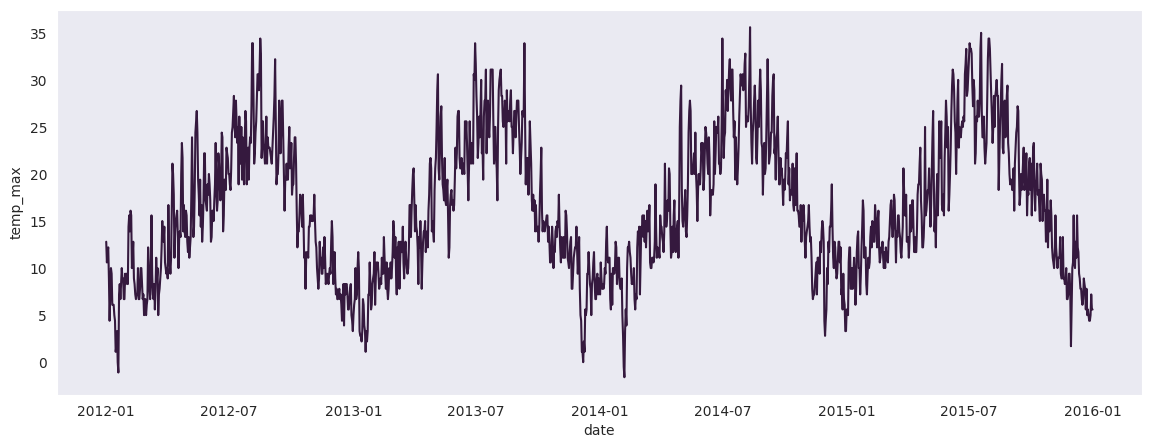

In [34]:
# timeseries plot of the temperature
plt.figure(figsize=(14,5))
sns.lineplot(df_temp);

In [35]:
# preprocesse the weather data into a format suitable for training an ML model
# create features by considering a window of past data points (defined by window_size)
# and use the data point following that window as the target variable
def df_to_XY(df,window_size=10):
    df_np = df_temp.to_numpy()
    X = []
    y = []
    for i in range(len(df_np)-window_size):
        row = [[a] for a in df_np[i:i+window_size]]
        X.append(row)
        target = df_np[i+window_size]
        y.append(target)
    return np.array(X),np.array(y)

In [36]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))

1451 1451


In [37]:
# check the shapes of both X and y
print(X.shape)
print(y.shape)

(1451, 10, 1)
(1451,)


In [38]:
# split the data into training, testing, and validation sets
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]

# **LSTM Model**

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [40]:
model = Sequential()
model.add(LSTM(64,input_shape=(WINDOW,1)))
model.add(Dense(32,"relu"))
model.add(Dropout(0.2))
model.add(Dense(16,"relu"))
model.add(Dense(1,"linear"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19521 (76.25 KB)
Trainable params: 19521 (76.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
# define two callbacks and compile an ML model in Keras
# Callbacks are functions called during model training

callback1 = ModelCheckpoint('model/',save_best_only=True)
# ModelCheckpoint is used to save model weights during training
# "save_best_only=True" argument instructs the callback to only save the model
# weights when the validation loss improves (only saves the best performing model based on the validation set).

earlyStopping = EarlyStopping(monitor="val_root_mean_squared_error",patience=3,start_from_epoch=5,restore_best_weights=True,)
# EarlyStopping is used to stop the training process early if the validation loss fails to improve
# for a certain number of epochs. This helps prevent overfitting and reduces training time.
# here, the early stopping metric (monitor) is the validation RMSE
# patience=3 implies that if the validation RMSE doesn't improve for 3 consecutive epochs, training will stop
# start_from_epoch=5 means start monitoring after the 5th epoch.

model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=RootMeanSquaredError())

In [42]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, callbacks=[earlyStopping])

Epoch 1/100
25/25 [==============================] - 3s 26ms/step - loss: 270.5200 - root_mean_squared_error: 16.4475 - val_loss: 475.7685 - val_root_mean_squared_error: 21.8121
Epoch 2/100
25/25 [==============================] - 0s 7ms/step - loss: 253.7583 - root_mean_squared_error: 15.9298 - val_loss: 452.7006 - val_root_mean_squared_error: 21.2768
Epoch 3/100
25/25 [==============================] - 0s 8ms/step - loss: 236.5375 - root_mean_squared_error: 15.3798 - val_loss: 424.5623 - val_root_mean_squared_error: 20.6049
Epoch 4/100
25/25 [==============================] - 0s 7ms/step - loss: 218.3988 - root_mean_squared_error: 14.7783 - val_loss: 398.3114 - val_root_mean_squared_error: 19.9577
Epoch 5/100
25/25 [==============================] - 0s 7ms/step - loss: 199.2376 - root_mean_squared_error: 14.1152 - val_loss: 371.3259 - val_root_mean_squared_error: 19.2698
Epoch 6/100
25/25 [==============================] - 0s 8ms/step - loss: 182.5442 - root_mean_squared_error: 13.51

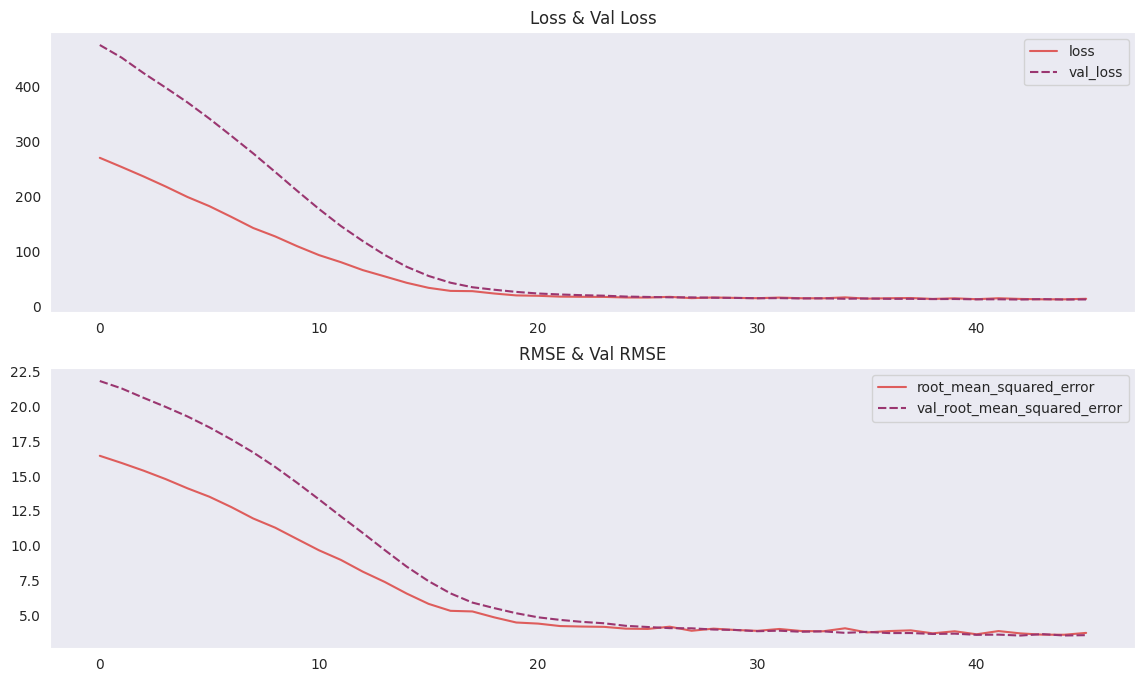

In [43]:
his = pd.DataFrame(history.history)
his.columns
history_loss = his[['loss', 'val_loss']]
history_rmse =  his[['root_mean_squared_error', 'val_root_mean_squared_error']]

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");

plt.subplot(2,1,2)
plt.title("RMSE & Val RMSE")
sns.lineplot(history_rmse,palette="flare");

## **Evaluation**

In [44]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

15/15 [==============================] - 0s 3ms/step


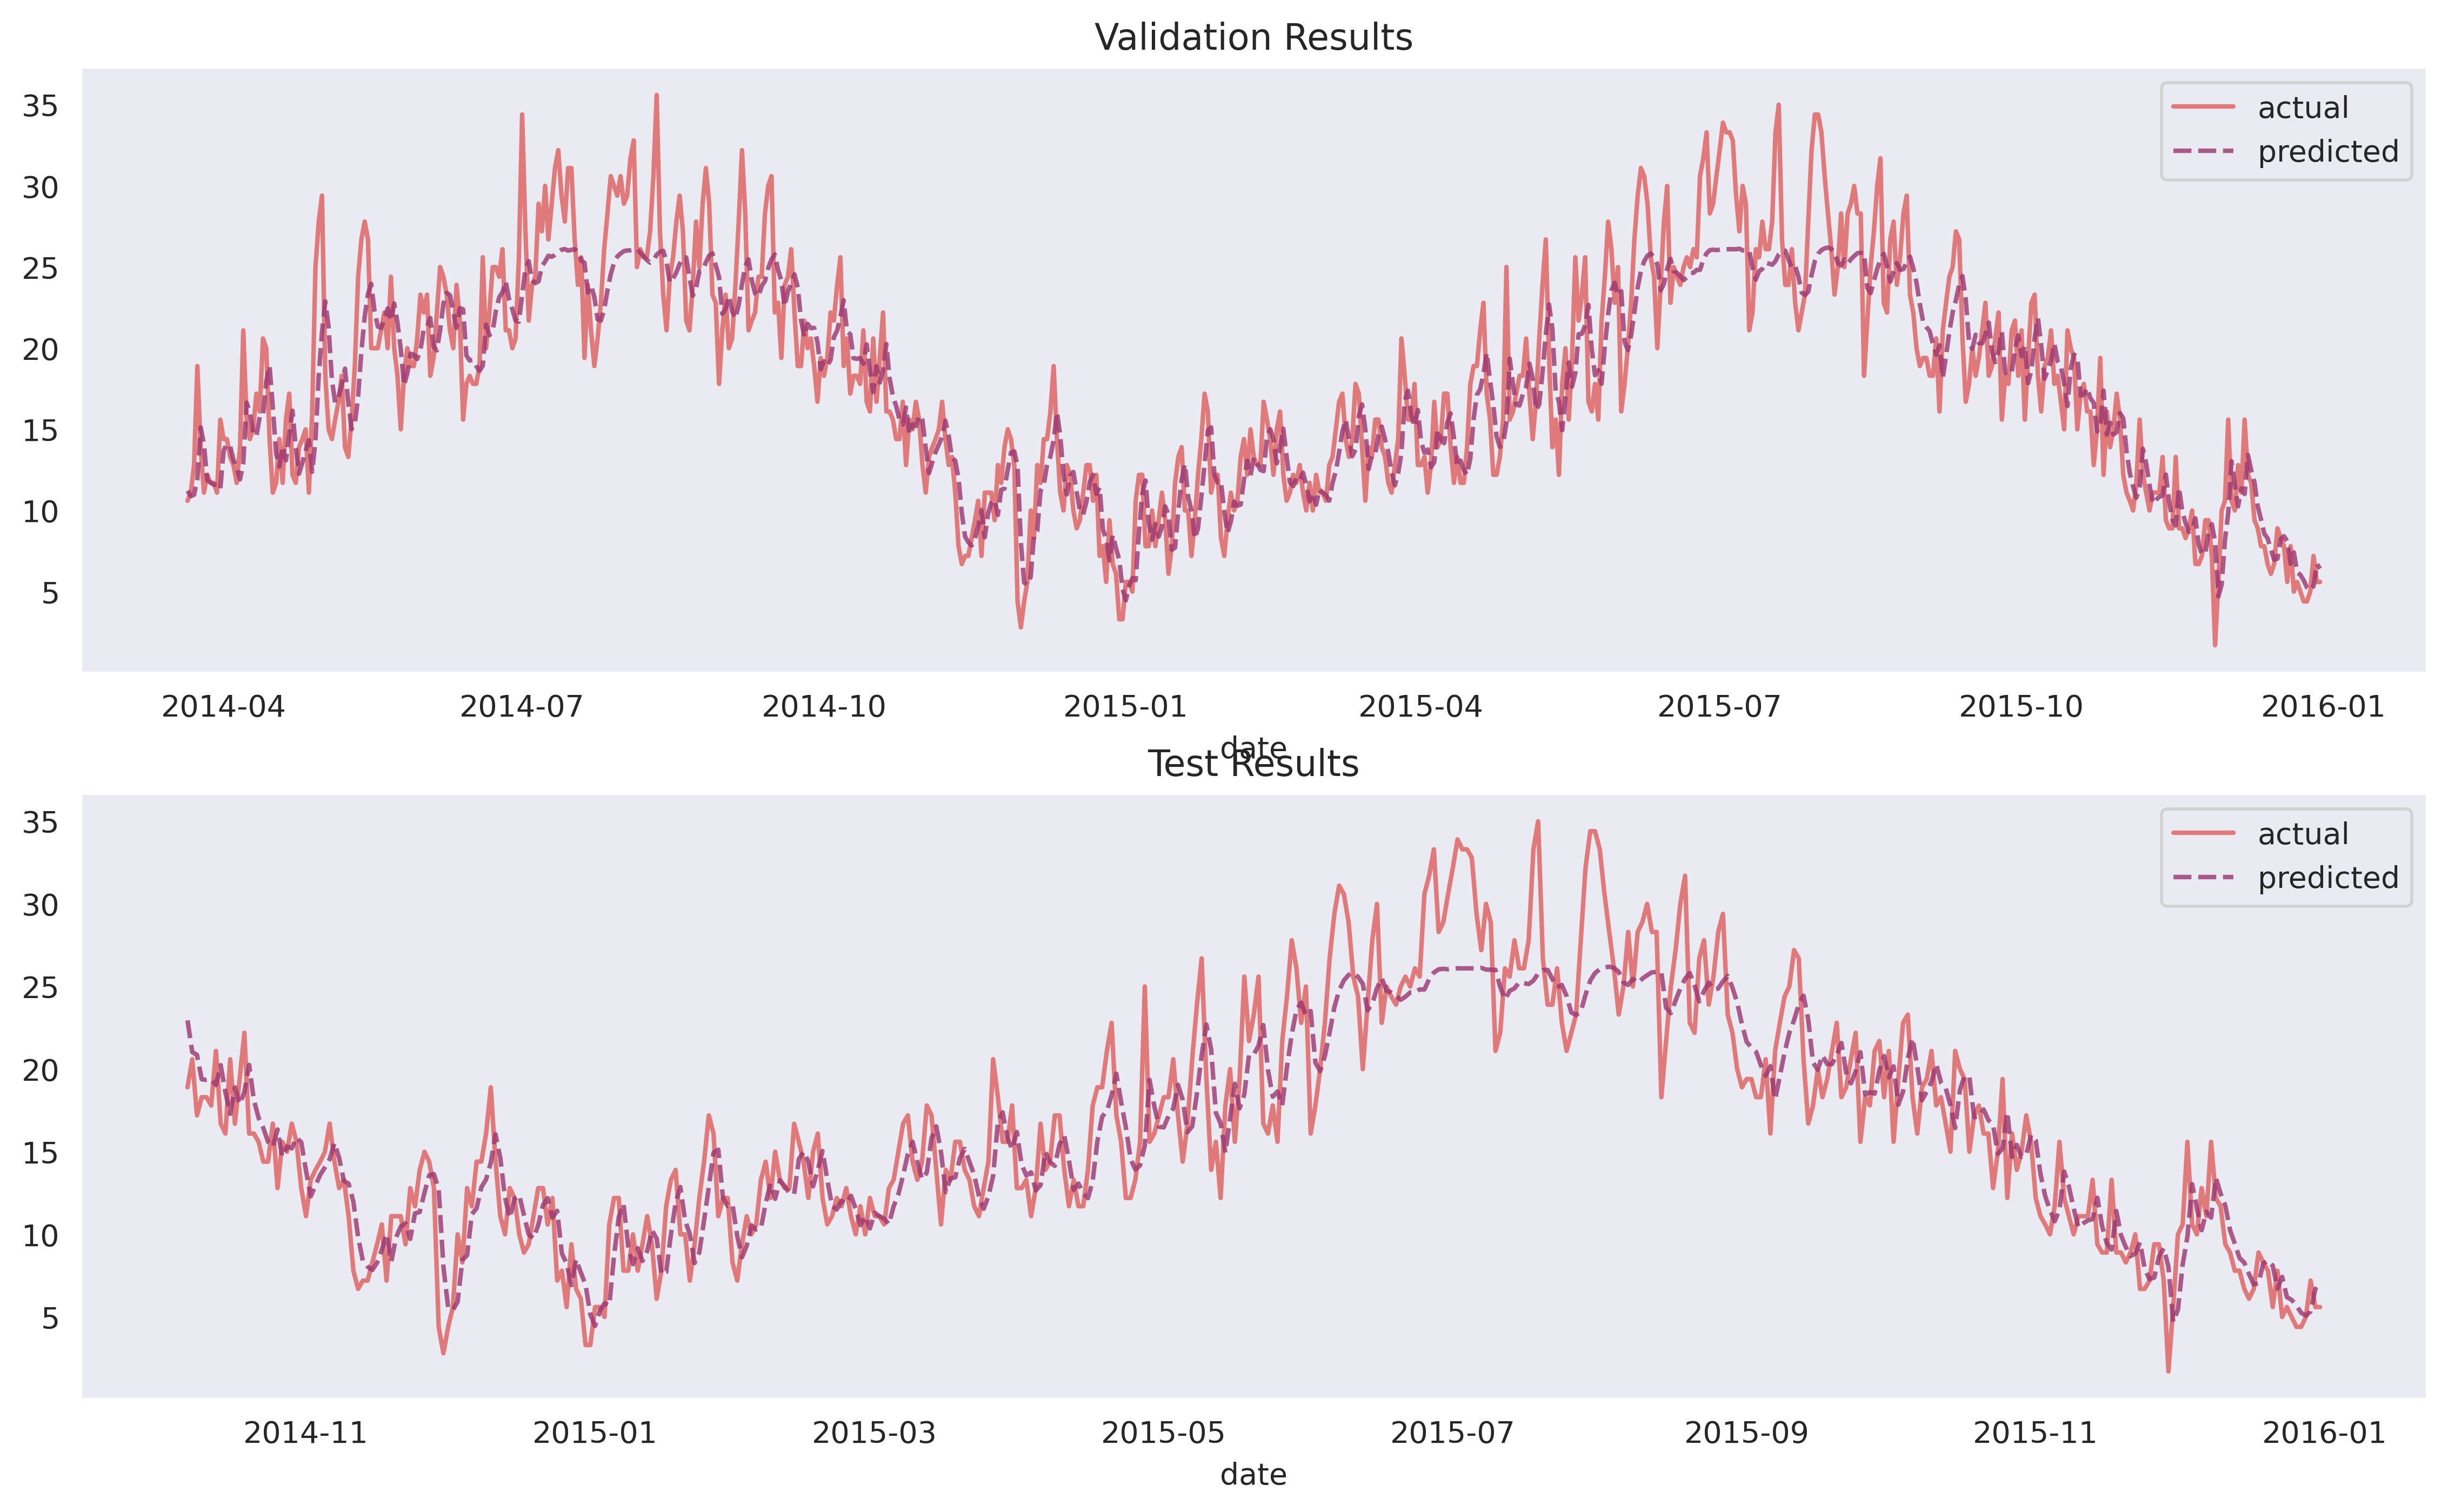

In [45]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);

# **RNN**

In [48]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

# Define window size
WINDOW = 10

# Define the model architecture
model = Sequential()

# Add an LSTM layer with 64 units and specify input shape
model.add(SimpleRNN(64, input_shape=(WINDOW, 1)))

# Add a Dense layer with 32 units and ReLU activation function
model.add(Dense(32, activation="relu"))

# Add a Dropout layer with dropout rate 0.2
model.add(Dropout(0.2))

# Add a Dense layer with 16 units and ReLU activation function
model.add(Dense(16, activation="relu"))

# Add a Dense layer with 1 unit for regression output
model.add(Dense(1, activation="linear"))

# Print model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6849 (26.75 KB)
Trainable params: 6849 (26.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [50]:
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, batch_size=32)

Epoch 1/100
25/25 [==============================] - 2s 21ms/step - loss: 198.3126 - val_loss: 243.2544
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 70.1084 - val_loss: 63.4644
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 24.7809 - val_loss: 20.4751
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 14.7733 - val_loss: 11.9358
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 12.8845 - val_loss: 10.6027
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 12.5763 - val_loss: 10.6860
Epoch 7/100
25/25 [==============================] - 0s 6ms/step - loss: 11.9512 - val_loss: 10.5517
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 12.3184 - val_loss: 10.2636
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 11.6502 - val_loss: 10.6118
Epoch 10/100
25/25 [==============================] - 0s 5ms/step - loss: 11.3605 - val_

In [51]:
his = pd.DataFrame(history.history)

In [52]:
his.head()

,loss,val_loss
0,198.312592,243.254379
1,70.108368,63.464439
2,24.780935,20.475143
3,14.773294,11.935764
4,12.884516,10.602730


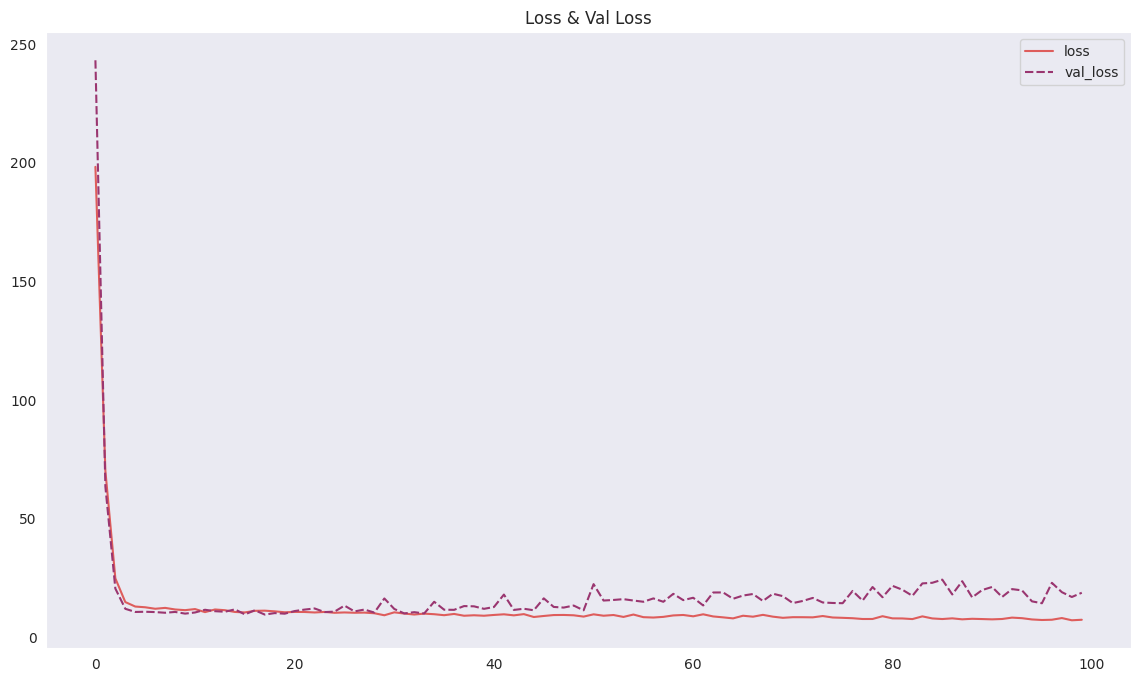

In [55]:
import seaborn as sns
his.columns
history_loss = his[['loss', 'val_loss']]
# history_rmse =  his[['root_mean_squared_error', 'val_root_mean_squared_error']]

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(1,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");

# plt.subplot(2,1,2)
# plt.title("RMSE & Val RMSE")
# sns.lineplot(history_rmse,palette="flare");

In [56]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

15/15 [==============================] - 0s 2ms/step


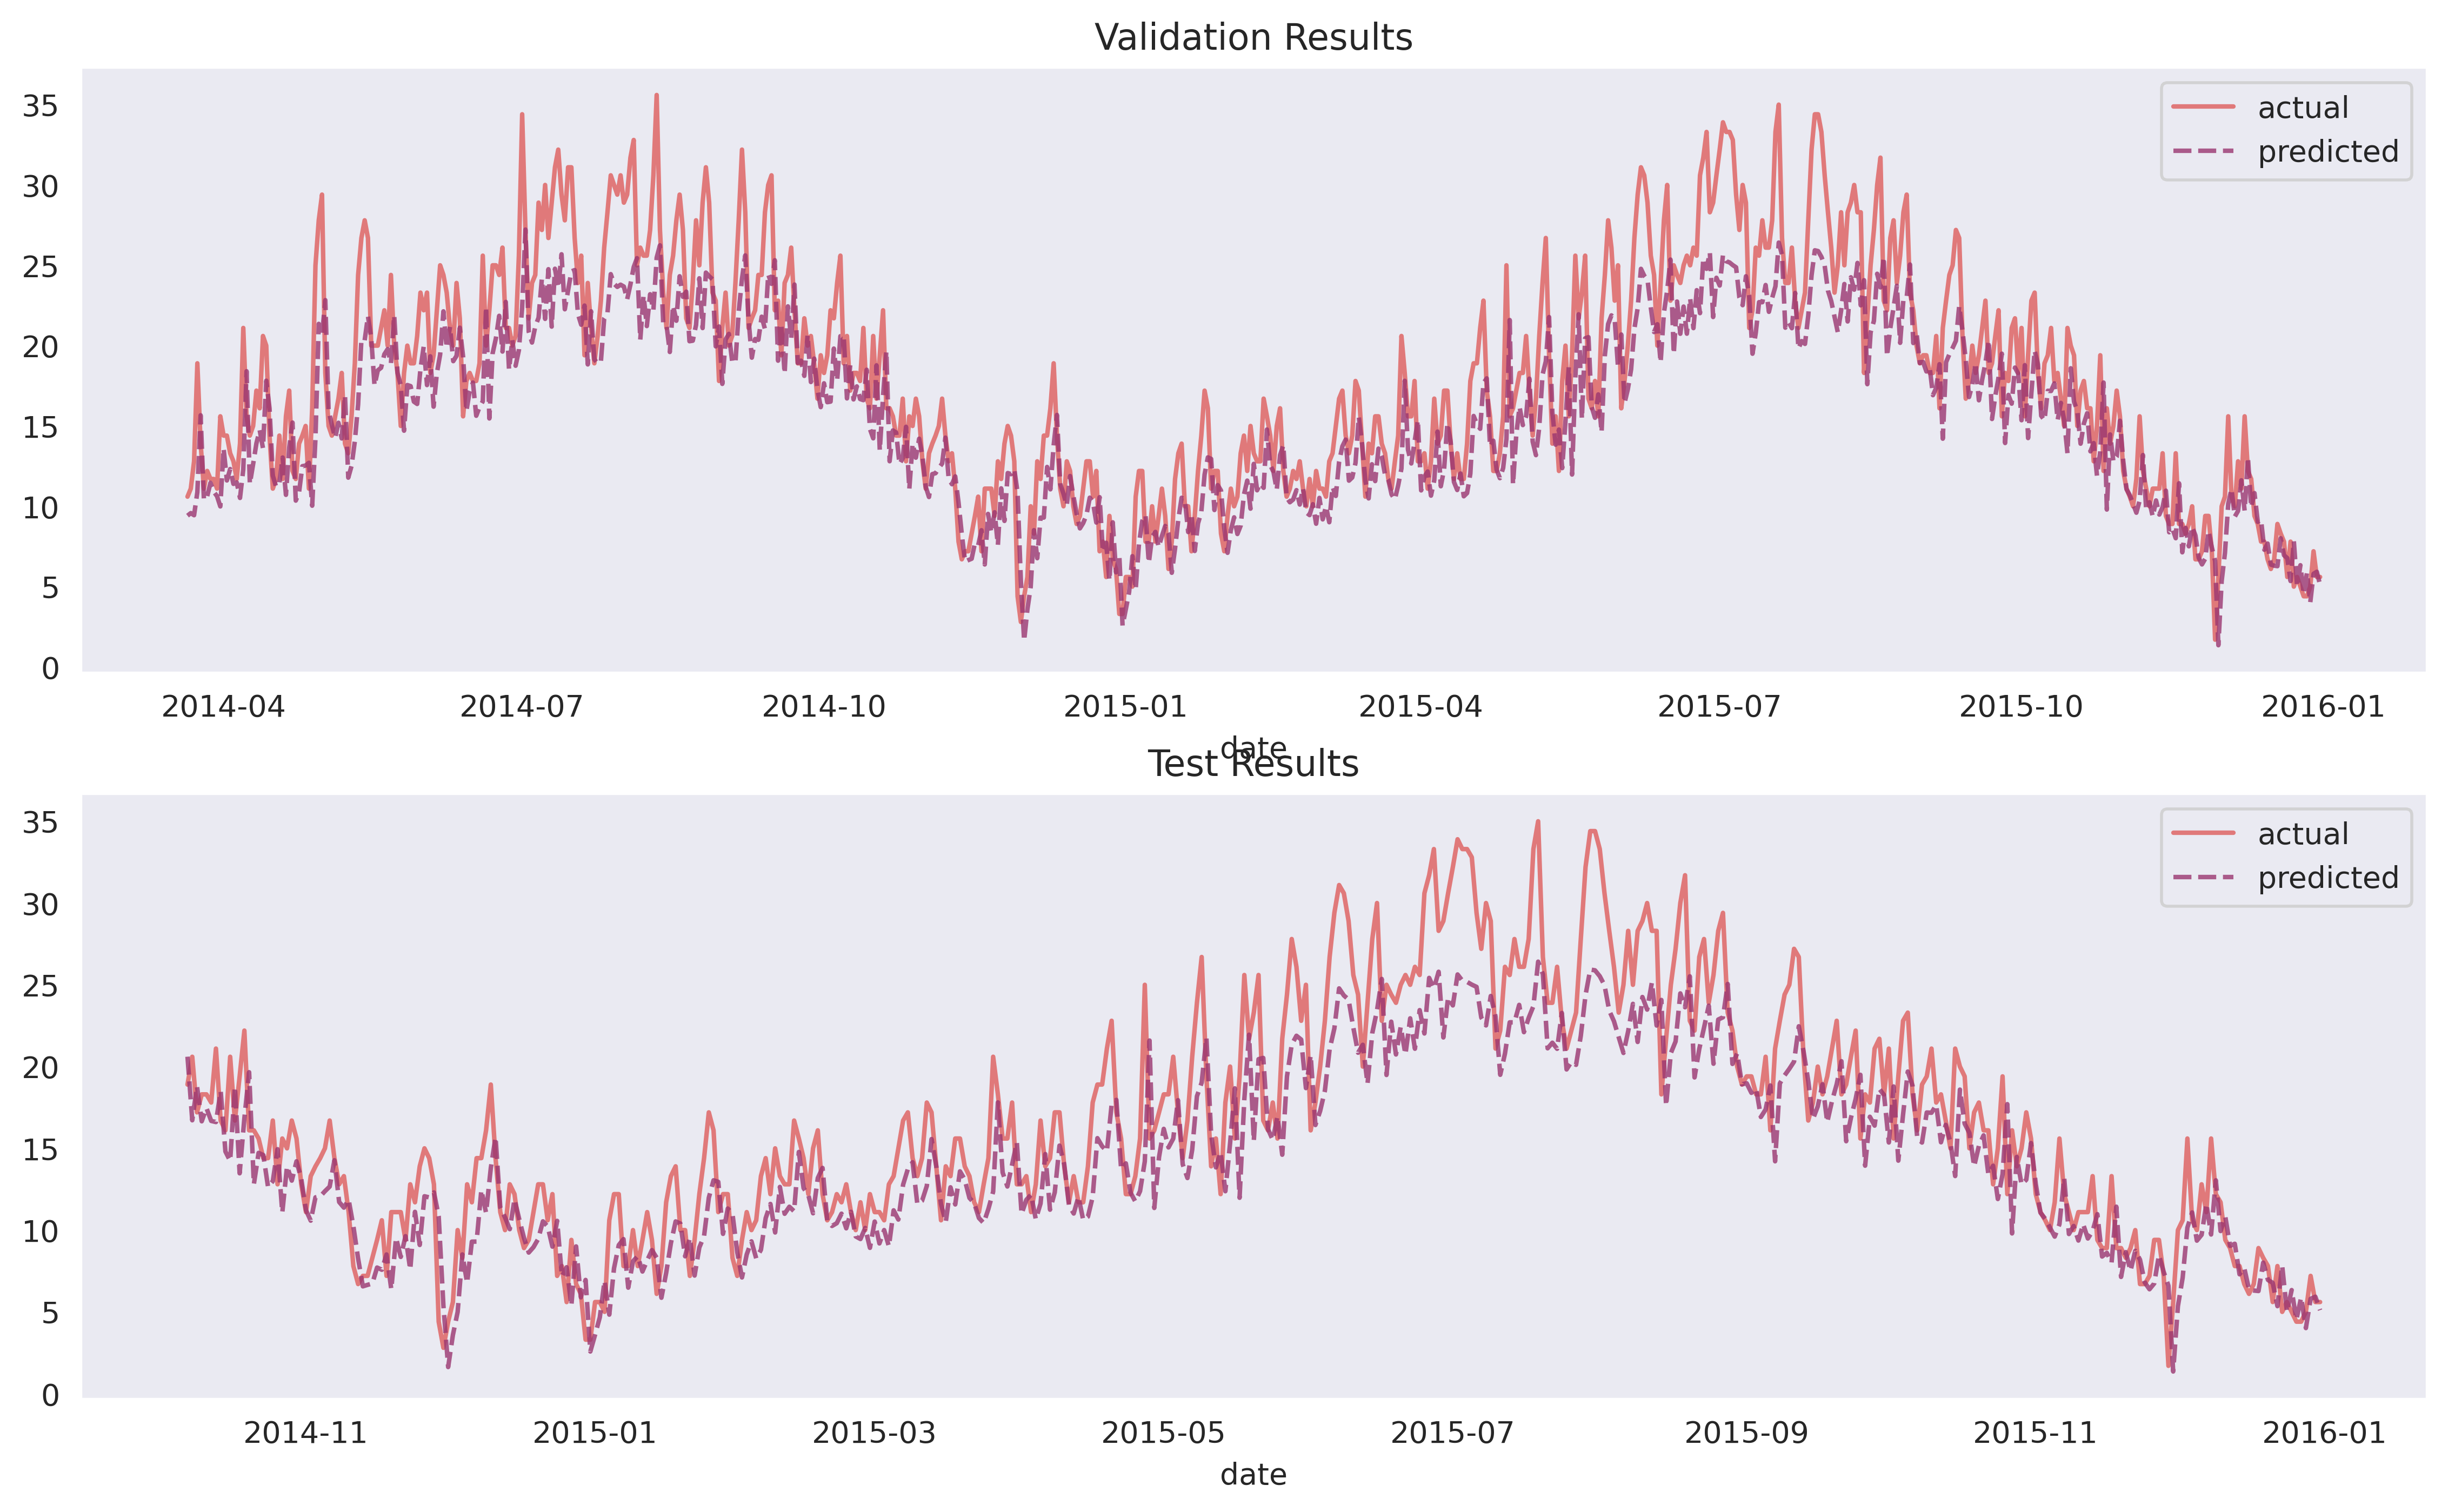

In [57]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);

# **Results**

* LSTM works better than RNN for predicting the weather.